([<matplotlib.axis.XTick at 0x7fa7ae217410>,
 <a list of 10 Text major ticklabel objects>)

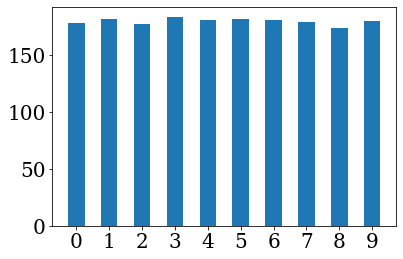

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import calinski_harabasz_score as ch_score
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.metrics.cluster import adjusted_rand_score as ars
from tqdm import tqdm
rcParams.update({'figure.autolayout': True})
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
rcParams["font.size"] = 20
rcParams['mathtext.fontset'] = 'stix'
rcParams["legend.frameon"] = False
rcParams["legend.shadow"] = True
rcParams['axes.titlesize'] = 16
rcParams['axes.titleweight'] = 'bold'



######### Load and segment digit data ######################
digits = load_digits()
X_orig = digits.images
X = digits.data
y = digits.target
class_names = digits.target_names


############# Visualize data ##############################
# plt.figure()
# for i in range(1,2*3+1):
#     index = np.random.randint(0,1797) 
#     ax1 = plt.subplot(2,3,i, title = "Class:"+str(y[index]))
#     ax1.imshow(X_orig[index])

############# Check label distribution ############################## 
plt.hist(y, bins = np.arange(11)-0.5, rwidth = 0.5)
plt.xticks(np.arange(10))

## **Implementation of Principal Component Analysis on the given dataset**

Principal component analysis (PCA) is a dimensionality reduction technique that is used as an unsupervised machine learning algorithm. PCA identifies the hyperplane nearest to the high dimensional data, and projects it to a lower dimensional subspace. 

The projection of data is done in such a way as to preserve the maximum variance of the data and miminize data lost through the reduction of dimension. The principal components (PCs) are the newly projected axes of the low-dimensional data. Here, ```x_t``` is the transformed data, having reduced dimensions.

```x_t``` is formed two times having different dimensions. 
1. First, the number of dimensions ```k ``` is selected to preserve at least 
90% of the energy of the original data of 64 dimensions. 
2. ```k = 3```

The clustering algorithm is executed for three cases, as given below: 

*   Original data (dimension = 64): ```X``` 
*   Centered Original data:  ```X_centered = X-X.mean(axis=0)```
*   PCA reduced data(dimension = $k$): ```x_t``` 









In [ ]:
######## Centered data #########
X_centered = X-X.mean(axis=0)

## Co-variance matrix A #######
A = (X_centered.T@X_centered)/X_centered.shape[0]
U, s, Ur = np.linalg.svd(A)

##### Select k for at least 90 percent feature preservation or k = 3 ###########
k = int(np.argwhere(np.cumsum(s)/np.cumsum(s)[-1]>0.90)[0])
# k = 3 # k-having only 3 dimensions

Ak = U[:,:k] @ np.diag(s[:k]) @ U[:,:k].T
#### New projected x after PCA #######
x_t = X_centered@U[:,:k]

## **K means clustering function.**
This function takes as input, the samples to be clustered, the corresponding labels, if any, the number of clusters, number of iterations and random seed for random initialization of the $k$ random means. 

The function returns the centroid of each of the $k$ cluster, the cluster prediction vector $\mathbf{c}$ that assigns cluster ID $c^{(i)}$ to each sample $x^{(i)}$, where $i\in[1,2,3\cdots m]$; $m=1797$ is the number of samples. The vector of loss function values  and accuracy of prediction for each iterations is also provided 

*   Inputs:  
> *   $x$: Data to be clustered. Numpy array of shape ($m,n$).
> *   $y$: Labels of the data. Numpy array of shape ($m$)
> *   ```num_cluster``` $k$: Number of clusters to divide the data into. Data type  = ```int``` 
> *   ```numIter```: Number of iterations over the clustering algorithm. 
> *   ```seed```: THe seed for the random initialization of the $k$ clusters.

*   Outputs:  
> *   ```k_means```: The centroids of the $k$ clusters. Numpy array of shape ($k,n$). J_mat, acc_mat, CH_mat
> *   $c$: Predicted clusters of the data. Numpy array of shape ($m$) 
> *   ```J_mat```: Loss function $J$ for each iteration of the algorithm. Numpy array of shape (```numIter```) 
> *   ```CH_mat```: The Calinski-Harabasz index for each iteration of the algorithm. Numpy array of shape (```numIter```).
> *   ```acc_mat```: Accuracy of predicted clusters for each of the labels in $y$. Numpy array of shape (10). Accuracy is measured as $\frac{TP+TN}{TP+TN+FP+FN}$ where, 
>> * $TP$: True positive samples 
>> * $TN$: True negative samples 
>> * $FP$: False positive samples 
>> * $FN$: False negative samples







In [ ]:

def k_MeansCluster(x,y,num_cluster, numIter, seed=1234, ):
    J_mat = np.array([])
    acc_y = np.array([])
    adj_mat = np.array([])
    CH_mat = np.array([])
    np.random.seed(seed) # Randomize for k-means initialization
    k_means = x.min()+np.random.rand(num_cluster,x.shape[1])*(x.max()-x.min())

    for i in range(40):
        ####### Cluster assignment #####################
        c = np.argmin(np.linalg.norm((x[:,:,np.newaxis].repeat(num_cluster,2)-k_means.T),axis = 1), axis = 1)
        # print(c)
        ####### Move cluster ########################### 
        idx = np.argsort(c)
        split_idx = np.argwhere([c[idx][i-1]!=c[idx][i] for i in range(1,len(idx))]).reshape(-1)+1
        list_data = np.split(x[idx],split_idx)
        for j in range(len(list_data)):
            k_means[j] = list_data[j].mean(axis=0)
        
        J = np.mean(np.square(np.linalg.norm(x-k_means[c], axis=1)))
        adj_score =ars(y,c) 
        
        # if i == 0:
            # print(J)
        J_mat = np.append(J_mat, J)
        adj_mat = np.append(adj_mat, adj_score)
        CH_mat = np.append(CH_mat, ch_score(x,c))

    
    for i in class_names:
      TP = sum((c == stat.mode(c[np.argwhere(y==i).reshape(-1)])[0]) & (y==i))
      FP = sum((c == stat.mode(c[np.argwhere(y==i).reshape(-1)])[0]) & (y!=i))
      FN = sum((c != stat.mode(c[np.argwhere(y==i).reshape(-1)])[0]) & (y==i))
      TN = sum((c != stat.mode(c[np.argwhere(y==i).reshape(-1)])[0]) & (y!=i))
      acc = (TP+TN)/y.shape[0]
      acc_y = np.append(acc_y, acc) 
    acc_avg = np.mean(acc_y)
    return k_means, c, J_mat, CH_mat, acc_avg, acc_y, adj_mat 

Text(0, 0.5, 'Accuracy (%)')

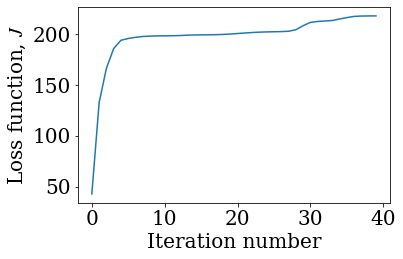

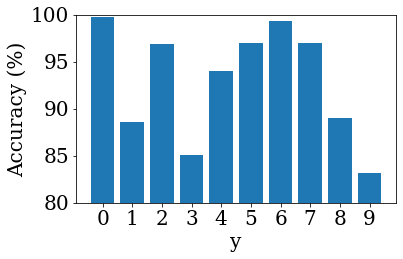

In [ ]:
#### Test clustering function ##############
num_cluster = 10
numIter = 40
seed = 1234

k_means, c, J_mat, CH_mat, acc, acc_mat, adj_score = k_MeansCluster(x_t,y,  num_cluster, numIter, seed)


# print(J)
plt.figure()
plt.plot(CH_mat)
plt.xlabel("Iteration number")
plt.ylabel("Loss function, $J$")

plt.figure()
plt.bar(class_names, 100*acc_mat)
plt.xticks(np.arange(10))
plt.ylim((80, 100))
plt.xlabel("y")
plt.ylabel("Accuracy (%)")

## **Subset generation function.**
This function takes as input, the samples  to be clustered (and labels). Other inputs include the proportion of the training set to be sampled as a new training set and the distribution of labels required in the sampled set. The function randomly samples a subset of the entire training set, according to the distribution of labels requred in the sampled set.  

The sampled traing set (and labels) are provided as outputs.
**The sampled subset is balanced in its distribution of samples. A balanced subset of data has been sampled, to ensure validity of the generated subsets**


([<matplotlib.axis.XTick at 0x7fa7aeab71d0>,
 <a list of 10 Text major ticklabel objects>)

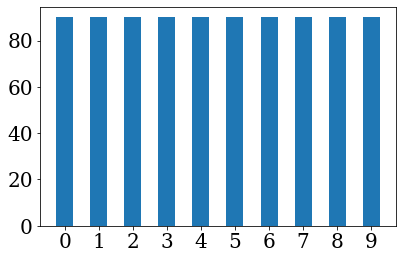

In [ ]:

def select_subset_from_sample(x,y, class_names, ratio, ratio_per_label):
      num_per_label = np.round(ratio_per_label*int(ratio*x.shape[0])).astype(int)
      dist_labels = {a-1:v for a,v in enumerate(num_per_label)}
      sampled_idx = np.array([]).astype(int)
      for a in dist_labels.keys():
        idx = np.argwhere(y==class_names[a]).astype(int)
        idx = np.random.permutation(idx)
        num = min(dist_labels[a], len(idx))

        idx = idx[:num]

        sampled_idx = np.append(sampled_idx, idx)

      return x[sampled_idx], y[sampled_idx]
      
#### Test for sampling a balanced dataset #####
ratio = 0.5
ratio_per_label = np.ones(len(class_names))/len(class_names)

x_sampled, y_sampled = select_subset_from_sample(x_t, y, class_names, ratio, ratio_per_label)

plt.hist(y_sampled, bins = np.arange(11)-0.5, rwidth = 0.5)
plt.xticks(np.arange(10))

# **Clustering Loop: (a) For different number of samples**
The ```vary_samples``` function implements the clustering algorithm for different sample sizes and stores the performance indices and the clustering centroida and IDs for the largest sample size. The inputs and outputs of this fuction is given below:  
*   Inputs:  
> *   $x$: Data to be clustered. Numpy array of shape ($m,n$).
> *   $y$: Labels of the data. Numpy array of shape ($m$)
> *   ```class_names```: Numpy array of class labels (i.e., digits from $0$ to $10$). Data type  = ```int``` 
> *   ```num_cluster``` $k$: Number of clusters to divide the data into. Data type  = ```int``` 
> *   ```numIter```: Number of iterations over the clustering algorithm. 
> *   ```seed```: THe seed for the random initialization of the $k$ clusters.
> *   ```ratio```: The proportion of dataset ($x$) to be considered for clustering. numpy array of floats. 
> *   ```ratio_per_label```: The sampling distribution of labels for sampling the subset of $x$. Samples are chosen based upon the relative distribution of each class. numpy array of floats.

*   Outputs:  
> *   ```JvsSample```: Final loss function value $J$ for each sample size. Numpy array of shape ($m$). 
> *   ```accVsSample```: Average accuracy for different sample sizes. Numpy array of shape  ($m$).
> *   ```CHvsSample```:The Calinski-Harabasz index for different sample sizes. Numpy array of shape  ($m$). 
> *   ```k_means```: The centroids of the $k$ clusters for the final (largest) sample size. Numpy array of shape ($k,n$). 
> *   $c$: Predicted clusters of the data for the final (largest) sample size. Numpy array of shape ($m$). 

In [ ]:
def vary_samples(x, y, class_names,num_cluster, numIter, ratio, ratio_per_label, seed):
  
  JvsSample = np.array([])
  accVsSample = np.array([])
  CHvsSample = np.array([])
  adjVsSample = np.array([])
  for r in tqdm(ratio):
    x_sampled, y_sampled = select_subset_from_sample(x, y, class_names, r, ratio_per_label)
    k_means, c, J_mat, CH_mat, acc_avg, acc_mat, adj_score = k_MeansCluster(x_sampled, y_sampled,  num_cluster, numIter, seed)
    
    JvsSample = np.append(JvsSample, J_mat[-1])
    CHvsSample = np.append(CHvsSample, CH_mat[-1])
    accVsSample = np.append(accVsSample, acc_avg)
    adjVsSample = np.append(adjVsSample, adj_score[-1])

  return [JvsSample, accVsSample, CHvsSample, adj_score], [k_means, c]

In [ ]:
### Sample training data #######
ratio = np.linspace(0,1,51)[1:]
ratio_per_label = np.ones(len(class_names))/len(class_names) # Equal ratio for all labels
num_cluster = 10
numIter = 40
seed = 1234
### Clustering with original data and PCA decomposed data ###
performance, k = vary_samples(X, y, class_names, num_cluster, numIter, ratio, ratio_per_label, seed)
performance_center, k_center = vary_samples(X_centered, y, class_names, num_cluster, numIter, ratio, ratio_per_label, seed)
performance_pca, k_pca = vary_samples(x_t, y, class_names, num_cluster, numIter, ratio, ratio_per_label, seed)

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [ ]:
performance, k = vary_samples(X, y, class_names, num_cluster, numIter, ratio, ratio_per_label, seed)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Text(0, 0.5, 'Accuracy (%)')

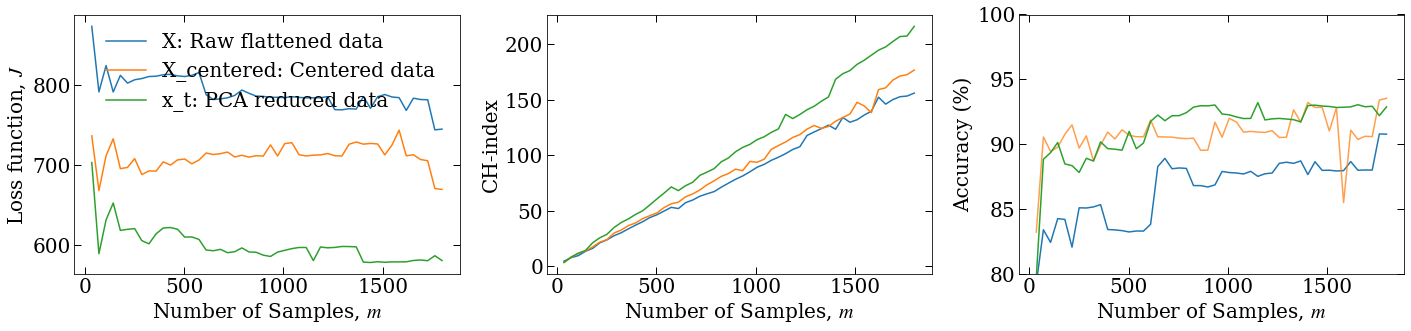

In [ ]:
##########=====================================================================
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(131)
ax1.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(ratio*X.shape[0], performance[0], label = "X: Raw flattened data ")
plt.plot(ratio*X.shape[0], performance_center[0], label = "X_centered: Centered data ")
plt.plot(ratio*X.shape[0], performance_pca[0], label = "x_t: PCA reduced data ")
plt.xlabel("Number of Samples, $m$")
plt.ylabel("Loss function, $J$")
lgd = plt.legend()
# plt.figure()

ax2 = plt.subplot(132,sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(ratio*X.shape[0], performance[2])
plt.plot(ratio*X.shape[0], performance_center[2])
plt.plot(ratio*X.shape[0], performance_pca[2])
plt.tick_params('y', labelbottom=False)
plt.xlabel("Number of Samples, $m$")
plt.ylabel("CH-index")

# plt.figure()

ax2 = plt.subplot(133, sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(ratio*X.shape[0], performance[1]*100)
plt.plot(ratio*X.shape[0], performance_center[1]*100, alpha = 0.75)
plt.plot(ratio*X.shape[0], performance_pca[1]*100, alpha = 1)
plt.ylim((80,100))
plt.xlabel("Number of Samples, $m$")
plt.ylabel("Accuracy (%)")

# plt.savefig("Vary_sample.png", dpi = 300)

# **Clustering Loop: (b) For different number of clusters**
The ```vary_cluster``` function implements the clustering algorithm for different number of clusters. Inputs and outputs are given below
*   Inputs:  
> *   $x$: Data to be clustered. Numpy array of shape ($m,n$).
> *   $y$: Labels of the data. Numpy array of shape ($m$)
> *   ```class_names```: Numpy array of class labels (i.e., digits from $0$ to $10$). Data type  = ```int``` 
> *   ```num_cluster``` $k$: Number of clusters to divide the data into. Data type  = ```int``` 
> *   ```numIter```: Number of iterations over the clustering algorithm. 
> *   ```seed```: THe seed for the random initialization of the $k$ clusters.


*   Outputs:  
> *   ```JvsCluster```: Final loss function value $J$ for each cluster size. Numpy array of shape ($m$). 
> *   ```accVsCluster```: Average accuracy for different cluster sizes. Numpy array of shape  ($m$).
> *   ```CHvsCluster```:The Calinski-Harabasz index for different cluster sizes. Numpy array of shape  ($m$). 
> *   ```k_means```: The centroids of the $k$ clusters for the final (largest) sample size. Numpy array of shape ($k,n$). 
> *   $c$: Predicted clusters of the data for the final (largest) sample size. Numpy array of shape ($m$). 

In [ ]:
def vary_cluster(x, y, class_names,num_cluster, numIter, seed):
  
  JvsCluster = np.array([])
  accVsCluster = np.array([])
  CHvsCluster = np.array([])
  for k in tqdm(num_cluster):
    # x_sampled, y_sampled = select_subset_from_sample(x, y, class_names, r, ratio_per_label)
    k_means, c, J_mat,  CH_mat, acc_avg, acc_mat, _= k_MeansCluster(x, y,  k, numIter, seed)
    
    JvsCluster = np.append(JvsCluster, J_mat[-1])
    accVsCluster = np.append(accVsCluster, acc_avg)
    CHvsCluster = np.append(CHvsCluster, CH_mat[-1])

  return [JvsCluster, accVsCluster, CHvsCluster], [k_means, c]

In [ ]:
num_cluster = np.arange(5,50,1)

performance, k = vary_cluster(X, y, class_names, num_cluster, numIter,  seed)
performance_center, k_center = vary_cluster(X_centered, y, class_names, num_cluster, numIter, seed)
performance_pca, k_pca = vary_cluster(x_t, y, class_names, num_cluster, numIter, seed)



100%|██████████| 45/45 [01:04<00:00,  1.43s/it]


Text(0, 0.5, 'Accuracy (%)')

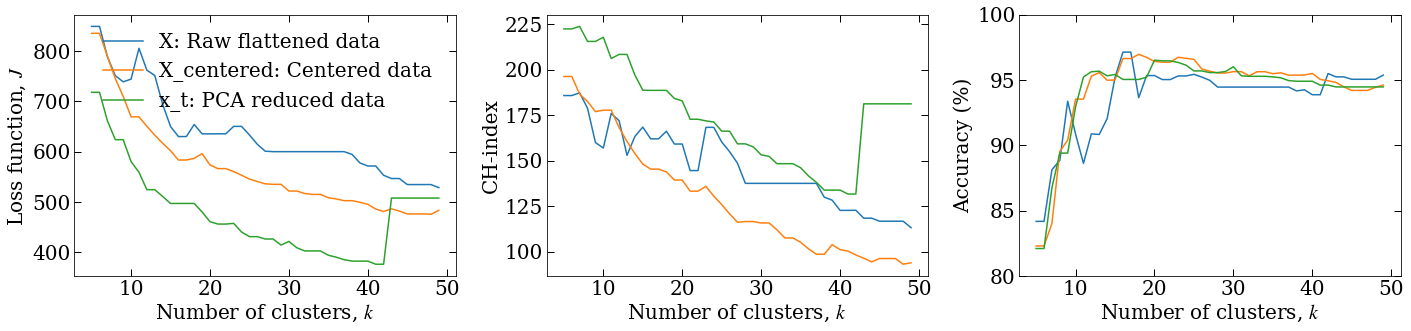

In [ ]:
##########=====================================================================
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(131)
ax1.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(num_cluster, performance[0], label = "X: Raw flattened data ")
plt.plot(num_cluster, performance_center[0], label = "X_centered: Centered data ")
plt.plot(num_cluster, performance_pca[0], label = "x_t: PCA reduced data ")
plt.xlabel("Number of clusters, $k$")
plt.ylabel("Loss function, $J$")
lgd = plt.legend()
# plt.figure()

ax2 = plt.subplot(132,sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(num_cluster, performance[2])
plt.plot(num_cluster, performance_center[2])
plt.plot(num_cluster, performance_pca[2])
plt.tick_params('y', labelbottom=False)
plt.xlabel("Number of clusters, $k$")
plt.ylabel("CH-index")

# plt.figure()

ax2 = plt.subplot(133, sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(num_cluster, performance[1]*100)
plt.plot(num_cluster, performance_center[1]*100)
plt.plot(num_cluster, performance_pca[1]*100)
plt.ylim((80,100))
plt.xlabel("Number of clusters, $k$")
plt.ylabel("Accuracy (%)")


# plt.savefig("Vary_cluster.png", dpi = 300)

# **Clustering Loop: (c) For different Initializations**
The ```vary_init``` function implements the clustering algorithm for different initializations of the clusters. Inputs and outputs are given below
*   Inputs:  
> *   $x$: Data to be clustered. Numpy array of shape ($m,n$).
> *   $y$: Labels of the data. Numpy array of shape ($m$)
> *   ```class_names```: Numpy array of class labels (i.e., digits from $0$ to $10$). Data type  = ```int``` 
> *   ```num_cluster``` $k$: Number of clusters to divide the data into. Data type  = ```int``` 
> *   ```numIter```: Number of iterations over the clustering algorithm. 
> *   ```seed```: THe seed for the random initialization of the $k$ clusters.

*   Outputs:  
> *   ```JvsInit```: Final loss function value $J$ for each initialization. Numpy array of shape ($m$). 
> *   ```accVsInit```: Average accuracy for different initializations. Numpy array of shape  ($m$).
> *   ```CHvsInit```:The Calinski-Harabasz index for different initializations. Numpy array of shape  ($m$). 
> *   ```k_means```: The centroids of the $k$ clusters for the final (largest) sample size. Numpy array of shape ($k,n$). 
> *   $c$: Predicted clusters of the data for the final (largest) sample size. Numpy array of shape ($m$).


In [ ]:
def vary_init(x, y, class_names,num_cluster, numIter, seed):
  
  JvsInit = np.array([])
  accVsInit = np.array([])
  CHvsInit = np.array([])
  for s in tqdm(seed):
    # x_sampled, y_sampled = select_subset_from_sample(x, y, class_names, r, ratio_per_label)
    k_means, c, J_mat,  CH_mat, acc_avg, acc_mat, _ = k_MeansCluster(x, y,  num_cluster, numIter, s)
    
    JvsInit = np.append(JvsInit, J_mat[-1])
    accVsInit = np.append(accVsInit, acc_mat[-1])
    CHvsInit = np.append(CHvsInit, CH_mat[-1])

  return [JvsInit, accVsInit, CHvsInit], [k_means, c]

In [ ]:
num_cluster = 10
seed = np.random.randint(1000, high=2000, size=50)

performance, k = vary_init(X, y, class_names, num_cluster, numIter,  seed)
performance_center, k_center = vary_init(X_centered, y, class_names, num_cluster, numIter, seed)
performance_pca, k_pca = vary_init(x_t, y, class_names, num_cluster, numIter, seed)


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Text(0, 0.5, 'Accuracy (%)')

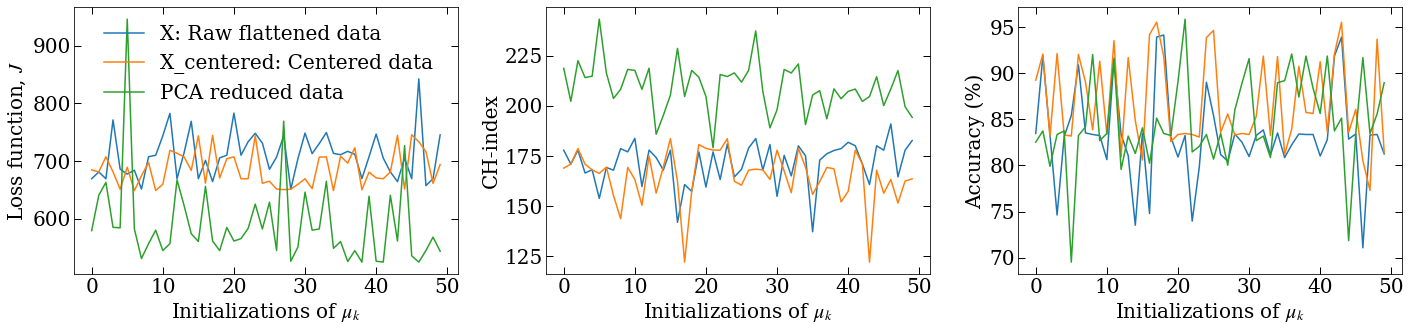

In [ ]:
##########=====================================================================
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(131)
ax1.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(performance[0],label = "X: Raw flattened data ")
plt.plot(performance_center[0], label = "X_centered: Centered data ")
plt.plot(performance_pca[0], label = "PCA reduced data ")
plt.xlabel("Initializations of $\mu_k$")
plt.ylabel("Loss function, $J$")
lgd = plt.legend()
# plt.figure()

ax2 = plt.subplot(132,sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(performance[2])
plt.plot(performance_center[2])
plt.plot(performance_pca[2])
plt.tick_params('y', labelbottom=False)
plt.xlabel("Initializations of $\mu_k$")
plt.ylabel("CH-index")

# plt.figure()

ax2 = plt.subplot(133, sharex = ax1)
ax2.tick_params(direction='in', length=7, width=1, 
                bottom=True, top=True, left=True, 
                right=True)
plt.plot(performance[1]*100)
plt.plot(performance_center[1]*100)
plt.plot(performance_pca[1]*100)
plt.xlabel("Initializations of $\mu_k$")
plt.ylabel("Accuracy (%)")



## **Observations**
# Reducing dimensions further
The loss values and accuracy of the original 64 dimension flattened data, and the PCA reduced data are quite close in value. The plots above show the results where the PCA reduced data has preserved 90% of its original energy. The reduced data has a dimension of 20. 

However, by further reducing the feature dimension of the data to 3 via PCA, the loss is seen to drastically decrease and the calinski-harabasz index increases almost by an order of magnitude. The trend of performance index for varying sample sizes, number of clusters and for different cluster initializations are shown below:


Figure: Variation of Loss function ($J$), Calinski-Harabasz (CH)-Index and accuracy with number of samples. Here, ```x_t``` has a dimension of 3. Only the CH-index increases almost linearly with the number of samples while $J$ and accuracy measure remain almost constant. 

Figure: Variation of Loss function ($J$), CH-Index and accuracy with number of clusters. Here, the PCA reduced data has a dimension of 3. Both $J$ and CH-index shows an exponential decay with the increase in cluster size and accuracy measure increases accordingly.  

In all cases, we find that the PCA reduced data in these cases show an exceptionally results in two of the performance indices, ($J$ and CH-index). However, The accuracy is not drastically different.

# Performance indices
The clustering algorithm for the three different datasets are analysed. As a performance measure, the clustering loss function defined by the equation below has been used.
$$ J(\mathbf{c}, \mu_1, \mu_2, \cdots, \mu_k) = \frac{1}{m}\sum_{i=1}^m {||x^{(i)}-\mu_c^{(i)}||_2}^2$$ 
Other than this loss function, the Calinski-Harabasz index and the accuracy measure of clustering, in relation to the original label data $y$, has been used as well. The formula of accuracy mesure has been shown in the previous section. 

These three performance indices show the results of the clustering algorithm for the three different datasets. 

In [86]:
# Reducing dimensions further
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('k_means_clustering.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/k_means_clustering.ipynb to pdf
[NbConvertApp] Support files will be in k_means_clustering_files/
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Making directory ./k_means_clustering_files
[NbConvertApp] Writing 323995 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'